While the 1D Ising model does not yet feature a phase transition, the 2D Ising model already does. This can be seen e.g. in the analytical result for the absolute magnetisation per particle for $H = 0$. where $T_{c}$ is the Curie temperature at which the phase transition occurs.
Implement a 2D Ising model on a square lattice with $n = \sqrt{N} = 20$ spins per side, again using periodic boundary conditions, $s_{n+1,j} = s_{1,j}$ and $s{i,n+1} = s{i,1}$, connecting sides with each other. Calculate the absolute magnetisation of the model for $H = 0$ in dependence of the thermal energy $k_{B}T$ with the same techniques used for the 1D model. Note that more time might be needed to reach equilibrium. Discuss your results. Can you reproduce the predicted phase transition?1


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
seeds = np.load("seeds_3000x100.npy")

In [93]:
#generating 100 lists 3000 seeds
#seeds = []
#for i in range(100):
#    seeds_i = np.random.randint(0, 100000, size=3000)
#    seeds.append(seeds_i)
#seeds = np.array(seeds)
#np.save("seeds_3000x100", seeds)

In [77]:
N = 20
X_0 = np.ones((N,N))
num_trials = 1000

def padding(a):
    bottom_row = np.array([a[-1]])
    top_row = np.array([a[0]])
    top_row_padded = np.concatenate((np.array([[0]]), top_row, np.array([[0]])), axis=1)
    bottom_row_padded = np.concatenate((np.array([[0]]), bottom_row, np.array([[0]])), axis=1)
    right_column = np.transpose([a[:,-1]])
    left_column = np.transpose([a[:,0]])
    a_cols = np.concatenate((right_column, a, left_column), axis=1)
    a_padded = np.concatenate((bottom_row_padded, a_cols, top_row_padded))
    return a_padded

def energy_2D(config, H_external=0, J=1):
    H = 0
    config_with_boundaries = padding(config)
    for i in range(1, config.shape[0]+1):
        for j in range(1, config.shape[1]+1):
            H_ij = config_with_boundaries[i][j]*(config_with_boundaries[i][j+1]+config_with_boundaries[i][j-1]+config_with_boundaries[i-1][j]+config_with_boundaries[i+1][j])
            H += H_ij
    H_ext = H_external * np.sum(config)
    return -(J*H/2+H_ext)

def metropolis_algorithm(initial_state, num_trials, beta=1, H_external=0, list_seeds=None):
    sequence_states = [initial_state]
    for n in range(num_trials):
        try:
            sd = list_seeds[n]
        except:
            sd = np.random.randint(1000)
        next = metropolis_step(sequence_states[-1], beta, H_external, seed = sd)
        sequence_states.append(next)
    return np.array(sequence_states), np.arange(num_trials+1) #sequences and corresponding time steps

def metropolis_step(current_state, beta, H_external, seed = None):
    np.random.seed(seed)
    spin_flip_index = np.random.randint(0,len(list(current_state)), size=2)
    trial_configuration = current_state
    trial_configuration[spin_flip_index[0]][spin_flip_index[1]] *= -1
    energy_diff = energy_2D(trial_configuration, H_external) - energy_2D(current_state, H_external)
    trial_acceptance_prob = np.min([np.exp(-beta * energy_diff),1])
    #r_propose = np.random.rand()
    r_accept = np.random.rand()
    if r_accept < trial_acceptance_prob:
        new_state = trial_configuration
    else:
        new_state = current_state
    return np.array(new_state)

def magnetisation(config):
    return np.sum(config)

def magnetisation_theor(beta, J=1):
    kT_c = 2.269185
    if 1/beta > kT_c:
        return 0
    else:
        z = np.exp(-2*J*beta)
        m_enum_1 = (1+z**2)**(1/4)
        m_enum_2 = (1-6*z**2 +z**4)**(1/8)
        m_denom = np.sqrt(1-z**2)
        return m_enum_1*m_enum_2/m_denom

In [90]:
list_beta = 1/np.linspace(1,4,10)

list_M = []

for beta in list_beta:
    list_M_beta = []
    print(f"Metropolis algorithm for beta={beta} starting time:", datetime.datetime.now())
    for m in range(10):
        states_m, _ = metropolis_algorithm(X_0, 3000, beta, list_seeds=seeds[m])
        states_m = states_m[-1000:,:] #Keep only the equilibrium states
        mag_m = [magnetisation(state) for state in states_m]
        list_M_beta.append(mag_m)
    M_mean = np.mean(list_M_beta)
    list_M.append(M_mean)

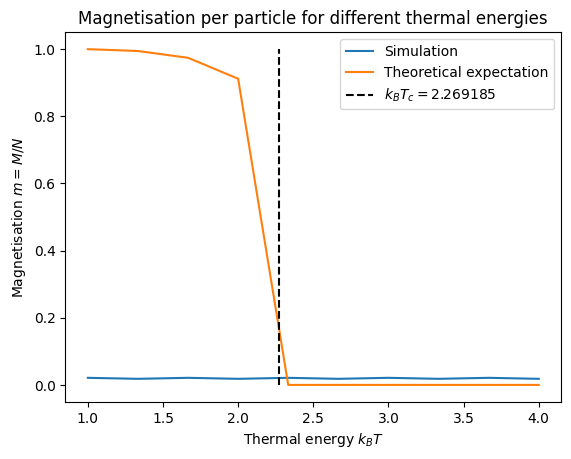

In [95]:
plt.plot(1/list_beta, np.array(list_M)/(N*N), label = "Simulation")
plt.plot(1/list_beta, [magnetisation_theor(b) for b in list_beta], label = f"Theoretical expectation")
plt.vlines(2.269185, 0, 1, "k", linestyles="dashed", label="$k_{B}T_{c}=2.269185$")
plt.title("Magnetisation per particle for different thermal energies")
plt.xlabel("Thermal energy $k_{B}T$")
plt.ylabel("Magnetisation $m = M/N$")
plt.legend()

In [92]:
list_M

[8.4508,
 7.2604,
 8.4508,
 7.2604,
 8.4508,
 7.2604,
 8.4508,
 7.2604,
 8.4508,
 7.2604]